# Import required modules

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
# torch.cuda.set_device(0)
# specify dtype: using gpu or cpu, since it's a tutorial, we use CPU only
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    #change the following if you wanna use GPU
    #dtype = torch.cuda.FloatTensor
    dtype = torch.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())

True
1


# 1. Tensor

In [4]:
# easy conversion with np array
# torch.Tensor -> numpy array
a = torch.ones(5)
b = a.numpy()
print(a)
print(b)
# change one will change the other
a.add_(1)
print(a)
print(b)


 1
 1
 1
 1
 1
[torch.FloatTensor of size 5]

[ 1.  1.  1.  1.  1.]

 2
 2
 2
 2
 2
[torch.FloatTensor of size 5]

[ 2.  2.  2.  2.  2.]


In [5]:
# numpy array -> torch.Tensor
a = np.ones(5)
b = torch.from_numpy(a)
print(a)
print(b)

[ 1.  1.  1.  1.  1.]

 1
 1
 1
 1
 1
[torch.DoubleTensor of size 5]



# 2. Variable

In [6]:
x = Variable(torch.ones(2, 2), requires_grad=False, volatile=False)
print(x)

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]



In [7]:
x.data


 1  1
 1  1
[torch.FloatTensor of size 2x2]

In [8]:
# building a simple computational graph
N, D = 3, 4
x = Variable(torch.randn(N, D), requires_grad=True)
y = Variable(torch.randn(N, D), requires_grad=True)
z = Variable(torch.randn(N, D), requires_grad=True)

a = x*y
b = a+z
c = torch.sum(b)

#uncomment follwing if you want to see a, b gradient
#a.register_hook(print)
#b.register_hook(print)

c.backward()

print(x.grad.data)
print(y.grad.data)
print(z.grad.data)


 1.4594  0.0182 -0.6046  1.1551
 0.5289 -1.3200 -0.3329  0.0394
-0.1296  0.3891  1.2356  0.9096
[torch.FloatTensor of size 3x4]


 1.9419 -0.3253  0.2197 -0.6253
-0.4759 -1.3381 -1.8406  0.3119
-0.3638  0.7474  0.0788 -1.4818
[torch.FloatTensor of size 3x4]


 1  1  1  1
 1  1  1  1
 1  1  1  1
[torch.FloatTensor of size 3x4]



# 3. torch.nn

In [9]:
# specify inputs
N, D_in, H, D_out = 64, 100, 50, 10
x = Variable(torch.randn(N, D_in)).type(dtype)
y = Variable(torch.randn(N, D_out)).type(dtype)

# define model
model = nn.Sequential(nn.Linear(D_in, H),
                     nn.ReLU(),
                     nn.Linear(H, D_out))

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# trianing
for t in range(5):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

# 4. Fine-tuning VGG on CIFAR10

In [10]:
# now use GPU
dtype = torch.cuda.FloatTensor

In [24]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
num_epoch = 2

In [13]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

# Data
data_path = '/home/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0))
testset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,5000))

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
10000
10000


In [16]:
# Helper functions
def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="test")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Test accuracy") 
    #plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([32, 3, 32, 32])


In [17]:
net = models.vgg16(pretrained=True).type(dtype)

In [18]:
new_classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 10)).type(dtype)

In [19]:
net.classifier = new_classifier
net

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [20]:
list(net.features.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU (inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [21]:
for i, (name, param) in enumerate(net.named_parameters()):
    print(name, param.data.size())

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
features.5.weight torch.Size([128, 64, 3, 3])
features.5.bias torch.Size([128])
features.7.weight torch.Size([128, 128, 3, 3])
features.7.bias torch.Size([128])
features.10.weight torch.Size([256, 128, 3, 3])
features.10.bias torch.Size([256])
features.12.weight torch.Size([256, 256, 3, 3])
features.12.bias torch.Size([256])
features.14.weight torch.Size([256, 256, 3, 3])
features.14.bias torch.Size([256])
features.17.weight torch.Size([512, 256, 3, 3])
features.17.bias torch.Size([512])
features.19.weight torch.Size([512, 512, 3, 3])
features.19.bias torch.Size([512])
features.21.weight torch.Size([512, 512, 3, 3])
features.21.bias torch.Size([512])
features.24.weight torch.Size([512, 512, 3, 3])
features.24.bias torch.Size([512])
features.26.weight torch.Size([512, 512, 3, 3])
features.26.bias torch.Size([512])
features.28.weight t

In [22]:
# test the model, check outpur size
x = Variable(torch.randn(1, 3, 32, 32)).type(dtype)
net(x)

Variable containing:
 0.7574 -0.2328 -0.5687  0.0817 -0.2118  0.2095 -0.0216 -0.1030  0.4516 -0.1083
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [23]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': net.features.parameters()},
           {'params': net.classifier.parameters(), 'lr': 1e-4}], lr=learning_rate, momentum=momentum)

In [25]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# start training
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss1 = []
    running_loss2 = []
    running_correct1=[]
    running_correct2=[]
    for i, data in enumerate(trainloader, 0):
        correct = 0
        net.train(True)
        # get the inputs
        inputs, labels = data
        # wrap them in Variable
        inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        # loss
        running_loss1.append(loss.data[0])
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()
        correct = correct/labels.size(0)*100
        running_correct1.append(correct)
        
    for i, tdata in enumerate(testloader, 0):
        test_correct = 0
        net.train(False)
        tinputs, tlabels = tdata
        tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
        toutput = net(tinputs)
        tloss = criterion(toutput, tlabels)
        running_loss2.append(tloss.data[0])
        _, tpredicted = torch.max(toutput.data, 1)
        test_correct += (tpredicted == tlabels.data).sum()
        test_correct = test_correct/tlabels.size(0)*100
        running_correct2.append(test_correct)
    
    train_loss.append(np.mean(running_loss1))
    test_loss.append(np.mean(running_loss2))
    train_acc.append(np.mean(running_correct1))
    test_acc.append(np.mean(running_correct2))
    
    #statistics
    print('Epoch [%d/%d], Loss: %.4f, Train Accuracy: %r percent' 
                %(epoch+1, num_epoch, train_loss[-1], train_acc[-1]))

print('Finished Training')

Epoch [1/2], Loss: 1.5406, Train Accuracy: 46.019273832373642 percent
Epoch [2/2], Loss: 0.9548, Train Accuracy: 66.418746001279587 percent
Finished Training


In [ ]:
# Save the Model
#torch.save(net.state_dict(), 'model.pkl')

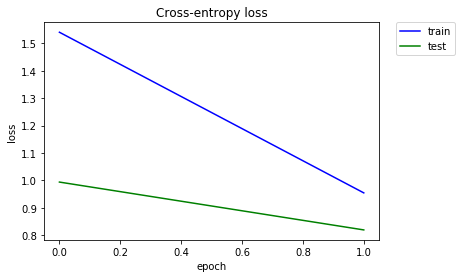

In [26]:
plot_losses(train_loss, test_loss)

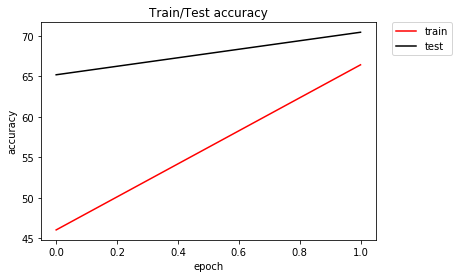

In [27]:
plot_accuracy(train_acc, test_acc)

In [28]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images).type(dtype))
        labels = Variable(labels).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net)

Accuracy of the network on the 10000 test images: 70 %


70.54